In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, metrics, decomposition, model_selection
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix


# Preprocessing 

##### Data exploration : getting info from the data, dropping unusefull features

In [2]:
# Data reading
data = pd.read_csv('Data/Water Quality Prediction.csv')

# Data info
data.info()
print(data.nunique())

# Unusefull feature dropping
features_to_drop = ['Index','Month','Day','Time of Day']
data.drop(columns=features_to_drop, inplace=True)

data.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 24 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Index                   1048575 non-null  int64  
 1   pH                      1028344 non-null  float64
 2   Iron                    1041584 non-null  float64
 3   Nitrate                 1029880 non-null  float64
 4   Chloride                1017741 non-null  float64
 5   Lead                    1043891 non-null  float64
 6   Zinc                    1020900 non-null  float64
 7   Color                   1047594 non-null  object 
 8   Turbidity               1039881 non-null  float64
 9   Fluoride                1015357 non-null  float64
 10  Copper                  1013693 non-null  float64
 11  Odor                    1017243 non-null  float64
 12  Sulfate                 1014050 non-null  float64
 13  Conductivity            1019772 non-null  float64
 14  Ch

,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,Copper,Odor,Sulfate,Conductivity,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Target
0,8.332988,0.000083,8.605777,122.799772,3.710000e-52,3.434827,Colorless,0.022683,0.607283,0.144599,1.626212,87.266538,471.683357,3.708178,2.270000e-15,332.118789,NaN,NaN,43.493324,0
1,6.917863,0.000081,3.734167,227.029851,7.850000e-94,1.245317,Faint Yellow,0.019007,0.622874,0.437835,1.686049,144.010981,432.844908,3.292038,8.020000e-07,284.641984,Lake,15.348981,71.220586,0
2,5.443762,0.020106,3.816994,230.995630,5.290000e-76,0.528280,Light Yellow,0.319956,0.423423,0.431588,3.414619,275.702107,990.201209,3.560224,7.007989e-02,570.054094,River,11.643467,44.891330,0
3,7.955339,0.143988,8.224944,178.129940,4.000000e-176,4.027879,Near Colorless,0.166319,0.208454,0.239451,NaN,147.163233,237.028468,3.516907,2.468295e-02,100.043838,Ground,10.092392,60.843233,0
4,8.091909,0.002167,9.925788,186.540872,4.170000e-132,3.807511,Light Yellow,0.004867,0.222912,0.616574,0.795310,175.275175,385.025855,3.177849,3.296139e-03,168.075545,Spring,15.249416,69.336671,0


#### NaN values location visualization 

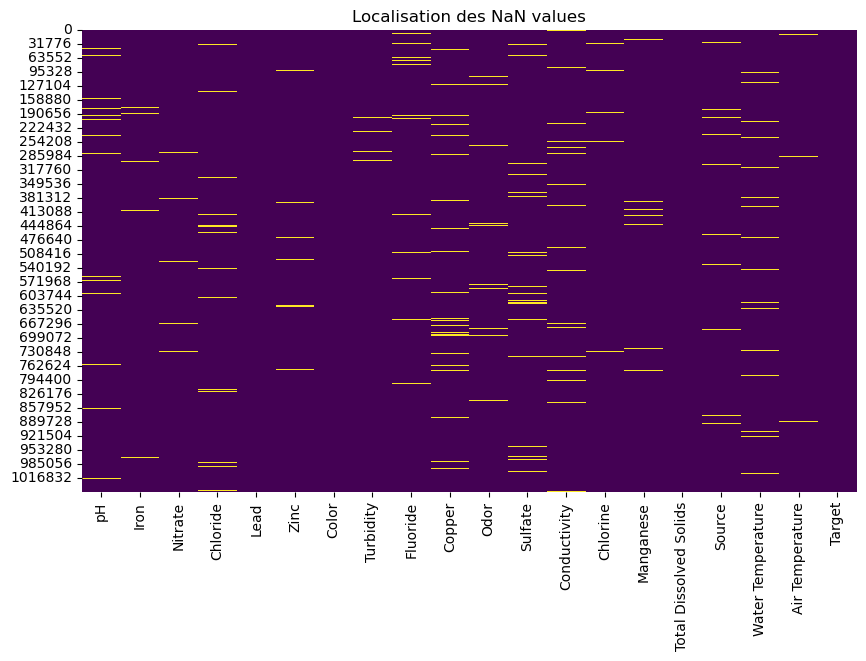

In [3]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.isna(), cbar=False, cmap="viridis")
plt.title("Localisation des NaN values")
plt.show()

#### Rate of NaN values before cleaning 

In [4]:
#Calcul du pourcentage de Nan values
n=data.shape[0]
print("Before dropping rows with NA values:\n", data.shape[0])

dataa = data.copy()
dataa = dataa.dropna(how='any')
print("After dropping rows with NA values:\n", dataa.shape[0])
print("percentage of na value ",((n-dataa.shape[0])/n)*100,'%') #On peut pas juste retirer les Nan values



Before dropping rows with NA values:
 1048575
After dropping rows with NA values:
 739148
percentage of na value  29.50928641251222 %


In [5]:
#Dropping rows with NA values in categorial features 

data.dropna(subset=['Color', 'Source'], inplace=True)
data.reset_index(drop=True, inplace=True)
print("Avant drop et fil :", data.isnull().sum())

Avant drop et fil : pH                        19924
Iron                       6876
Nitrate                   18417
Chloride                  30340
Lead                       4616
Zinc                      27241
Color                         0
Turbidity                  8559
Fluoride                  32690
Copper                    34285
Odor                      30833
Sulfate                   33991
Conductivity              28362
Chlorine                   9985
Manganese                 19026
Total Dissolved Solids      294
Source                        0
Water Temperature         29202
Air Temperature            5220
Target                        0
dtype: int64


#### Cleaning of quantitative features NaN values and decomposing categorical features

In [6]:
###### Quantitative data
data_num = data.select_dtypes(include=['float64', 'int64'])
data_num.fillna(data_num.mean(), inplace=True)


####### Qualitative data 
df_cat = data.select_dtypes(include=['object']).copy() 
df_cat['Color'] = df_cat['Color'].astype('category')
df_cat['Source'] = df_cat['Source'].astype('category')

cat_encoder = OneHotEncoder(sparse_output=False)
df_cat_1hot = cat_encoder.fit_transform(df_cat)

df_cat_1hot_df = pd.DataFrame(df_cat_1hot, columns=cat_encoder.get_feature_names_out(df_cat.columns))


###### Quantitative and qualitative data cleaned concatenation 

df = pd.concat([data_num, df_cat_1hot_df], axis = 1)
df.head()


,pH,Iron,Nitrate,Chloride,Lead,Zinc,Turbidity,Fluoride,Copper,Odor,...,Color_Near Colorless,Color_Yellow,Source_Aquifer,Source_Ground,Source_Lake,Source_Reservoir,Source_River,Source_Spring,Source_Stream,Source_Well
0,6.917863,0.000081,3.734167,227.029851,7.850000e-94,1.245317,0.019007,0.622874,0.437835,1.686049,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,5.443762,0.020106,3.816994,230.995630,5.290000e-76,0.528280,0.319956,0.423423,0.431588,3.414619,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,7.955339,0.143988,8.224944,178.129940,4.000000e-176,4.027879,0.166319,0.208454,0.239451,1.772712,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.091909,0.002167,9.925788,186.540872,4.170000e-132,3.807511,0.004867,0.222912,0.616574,0.795310,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,7.449720,0.000006,1.702584,162.828458,6.100000e-23,3.742464,0.504791,0.054562,0.851326,1.270483,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Data scaling using MixMax method

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
data.describe().loc[['min', 'mean', 'std', 'max']].T.style.background_gradient(axis=1)

,min,mean,std,max
pH,0.000000,0.497668,0.077494,1.000000
Iron,0.000000,0.007235,0.028060,1.000000
Nitrate,0.000000,0.079581,0.042634,1.000000
Chloride,0.000000,0.108814,0.046231,1.000000
Lead,0.000000,0.000367,0.008599,1.000000
Zinc,0.000000,0.053885,0.052350,1.000000
Turbidity,0.000000,0.025051,0.044421,1.000000
Fluoride,0.000000,0.073211,0.060661,1.000000
Copper,0.000000,0.043379,0.048905,1.000000
Odor,0.000000,0.426462,0.250640,1.000000


#### Correlation matrix visualisation 

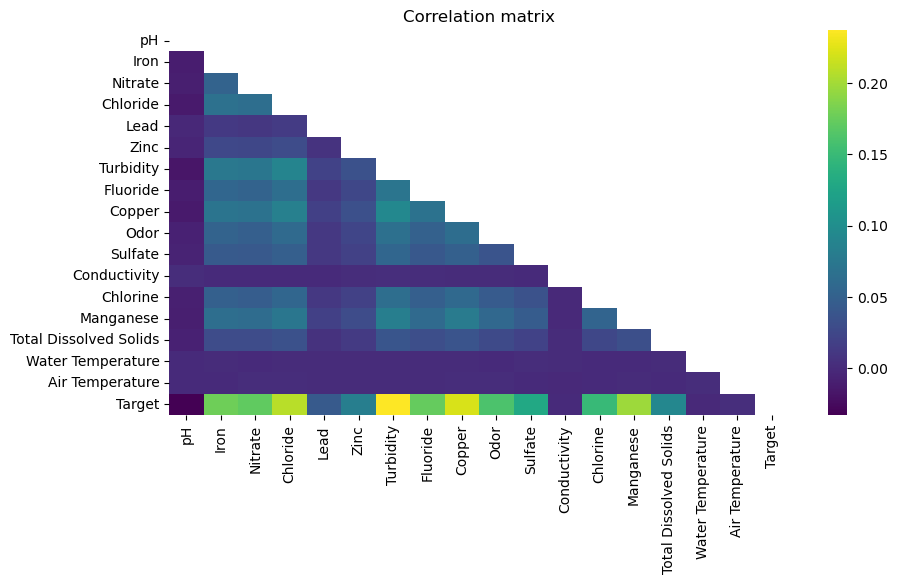

In [8]:
# Vérification des corrélations entre les features (que pour les quanti, pas de sens pour les quali)
plt.figure(figsize=(10, 5))
mask = np.triu(np.ones_like(data_num.corr(numeric_only=True), dtype=bool))
sns.heatmap(
    data_num.corr(numeric_only=True),
    annot=False, cmap="viridis", mask=mask, cbar=True
)
plt.title("Correlation matrix")
plt.show()

In [9]:
### C'est juste pour nous pour verifier mais ca dégage
print("Après fill :",data.isnull().sum())  

Après fill : pH                        0
Iron                      0
Nitrate                   0
Chloride                  0
Lead                      0
Zinc                      0
Turbidity                 0
Fluoride                  0
Copper                    0
Odor                      0
Sulfate                   0
Conductivity              0
Chlorine                  0
Manganese                 0
Total Dissolved Solids    0
Water Temperature         0
Air Temperature           0
Target                    0
Color_Colorless           0
Color_Faint Yellow        0
Color_Light Yellow        0
Color_Near Colorless      0
Color_Yellow              0
Source_Aquifer            0
Source_Ground             0
Source_Lake               0
Source_Reservoir          0
Source_River              0
Source_Spring             0
Source_Stream             0
Source_Well               0
dtype: int64


#### Rate of potable and non potable water in our dataset

Target
0.0    795079
1.0    236992
Name: count, dtype: int64


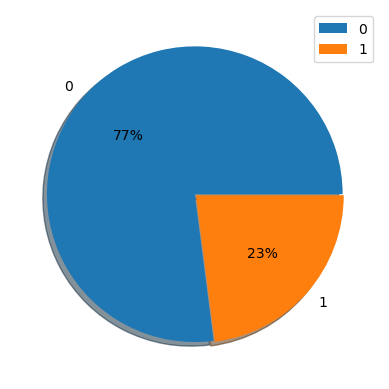

In [10]:
tar = data['Target'].value_counts()
print(tar)

plt.pie(tar, labels=[0, 1], explode=[0, 0.01], autopct='%.f%%', shadow=True)
plt.legend()
plt.show()

# Training 

### Split the data

In [11]:
# Séparation des données
x = data.drop('Target', axis=1)  # Toutes les colonnes sauf 'potability'
y = data['Target']               # Colonne cible

# Séparation en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


### Train different models

##### Logistic regression

Comparaison des Modèles :
                        Accuracy       AUC  F1 Score
Logistique regression  0.809239  0.853129  0.479883


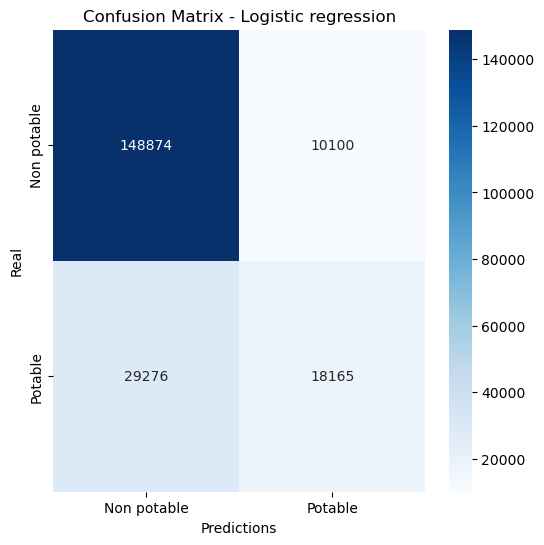

In [13]:
model = LogisticRegression()

results = {}

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_probs = model.predict_proba(x_test)[:, 1]  # Probabilités pour la classe 1 (potable)

# Calcul des métriques
accuracy = metrics.accuracy_score(y_test, y_pred)
auc_score = auc(*roc_curve(y_test, y_probs)[:2])  # AUC de la courbe ROC
f1 = metrics.f1_score(y_test, y_pred)

results["Logistique regression"] = {
        'Accuracy': accuracy,
        'AUC': auc_score,
        'F1 Score': f1
    }

results_df = pd.DataFrame(results).T
print("Comparaison des Modèles :\n", results_df)

best_model_name = results_df['AUC'].idxmax()  # Choisir le modèle avec la meilleure AUC


# Matrice de confusion
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Non potable', 'Potable'], yticklabels=['Non potable', 'Potable'])
plt.title(f"Confusion Matrix - Logistic regression")
plt.xlabel('Predictions')
plt.ylabel('Real')
plt.show()


In [ ]:
############## Modélisation et sélection du meilleur modèle #############

# Liste des modèles à tester
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Dictionnaire pour stocker les résultats de performance
results = {}

# Entraînement et évaluation des modèles
for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_probs = model.predict_proba(x_test)[:, 1]  # Probabilités pour la classe 1 (potable)

    # Calcul des métriques
    accuracy = metrics.accuracy_score(y_test, y_pred)
    auc_score = auc(*roc_curve(y_test, y_probs)[:2])  # AUC de la courbe ROC
    f1 = metrics.f1_score(y_test, y_pred)
    
    # Stockage des résultats
    results[model_name] = {
        'Accuracy': accuracy,
        'AUC': auc_score,
        'F1 Score': f1
    }

# Affichage des résultats pour comparer les modèles
results_df = pd.DataFrame(results).T
print("Comparaison des Modèles :\n", results_df)

# Sélection du meilleur modèle basé sur l'AUC (ou une autre métrique comme Accuracy ou F1 Score)
best_model_name = results_df['AUC'].idxmax()  # Choisir le modèle avec la meilleure AUC
best_model = models[best_model_name]

print(f"\nLe meilleur modèle est : {best_model_name}")

### 21 mins

Comparaison des Modèles :
                      Accuracy       AUC  F1 Score
Logistic Regression  0.809040  0.853326  0.478783
Decision Tree        0.837274  0.768123  0.643909
Random Forest        0.875808  0.925270  0.780674
K-Nearest Neighbors  0.811283  0.812322  0.494563

Le meilleur modèle est : Random Forest


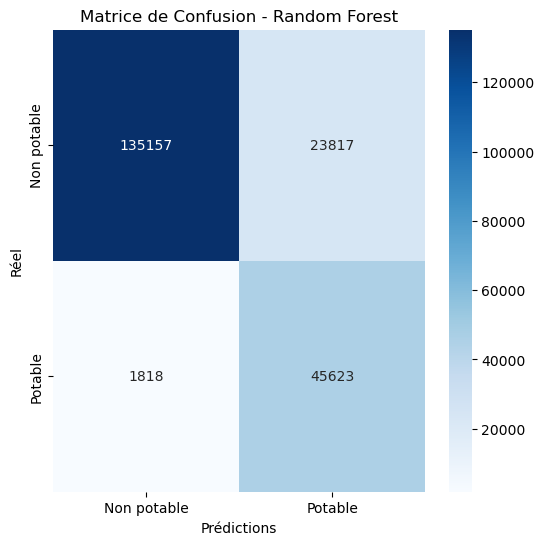


Classification Report pour Random Forest :
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91    158974
         1.0       0.66      0.96      0.78     47441

    accuracy                           0.88    206415
   macro avg       0.82      0.91      0.85    206415
weighted avg       0.91      0.88      0.88    206415



In [20]:
############# Évaluation du meilleur modèle #############

# Prédictions et évaluation du meilleur modèle
y_pred_best = best_model.predict(X_test)
y_probs_best = best_model.predict_proba(X_test)[:, 1]

# Matrice de confusion
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Non potable', 'Potable'], yticklabels=['Non potable', 'Potable'])
plt.title(f"Matrice de Confusion - {best_model_name}")
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.show()

# Classification Report
print(f"\nClassification Report pour {best_model_name} :")
print(classification_report(y_test, y_pred_best))


## PCA 

In [ ]:
model = RandomForestClassifier()
N_COMP = 15

pca = decomposition.PCA(n_components=N_COMP)
xp_train = pca.fit_transform(x_train)  
xp_test = pca.transform(x_test)


results = {}

model.fit(xp_train, y_train)
yp_pred = model.predict(xp_test)
yp_probs = model.predict_proba(xp_test)[:, 1]  # Probabilités pour la classe 1 (potable)


paccuracy = metrics.accuracy_score(y_test, yp_pred)
pauc_score = auc(*roc_curve(y_test, yp_probs)[:2])  # AUC de la courbe ROC
pf1 = metrics.f1_score(y_test, yp_pred)

presults = {}


presults["Random forest"] = {
        'Accuracy': paccuracy,
        'AUC': pauc_score,
        'F1 Score': pf1
    }

presults_df = pd.DataFrame(presults).T
print("Comparaison des Modèles :\n", presults_df)

print("C'était mieux avant")  

## 15 mins

Comparaison des Modèles :
                Accuracy       AUC  F1 Score
Random forest  0.823424  0.855372   0.56624
C'était mieux avant


#### Cross validation

In [ ]:
SCORINGS = "f1_weighted"

xp = np.vstack([x_train, x_test])
yp = np.hstack([y_train, y_test])

scores = model_selection.cross_val_score(
    model, xp, yp, cv=10, scoring=SCORINGS
)
with np.printoptions(precision=2):
    print(scores)

print(f"\n{SCORINGS}: {scores.mean():.3f}, with std dev: {scores.std():.3f}\n")

### 247 mins

[0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.88]

f1_weighted: 0.883, with std dev: 0.001



In [ ]:
#Résultat de la cross val (247mins)
#### Cross val avec fill by mean, randomforest, cv = 10 , scrorings = 'f1_weighted' 

# [0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.88]
#f1_weighted: 0.883, with std dev: 0.001

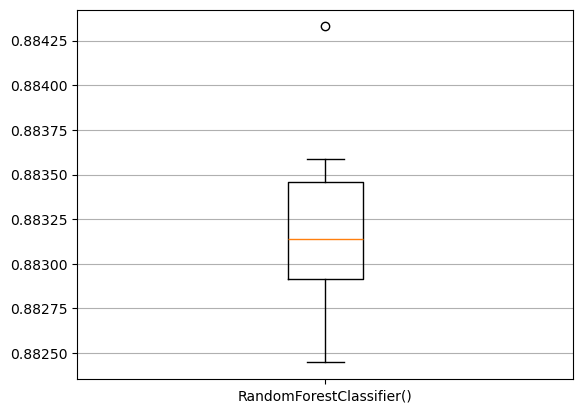

In [40]:
plt.boxplot(scores)
plt.xticks([1], [str(model)])
plt.grid(axis="y")
plt.show()